## import modules

In [1]:
import os
import pandas as pd
import re
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

---

## load data to pandas dataframe

In [2]:
path_dir = './log'
file_list = os.listdir(path_dir)
file_list.sort()
data = pd.DataFrame()
for file in file_list:
    now = pd.read_csv(f'./{file}', sep='\r\s', header=None, engine='python')
    data = pd.concat([data,now])
data[['date', 'time', 'serviceID', 'message']] = data[0].str.split(' ', n=3, expand=True)
warnings.filterwarnings(action='ignore')
data.describe()

,0,date,time,serviceID,message
count,219644,219644,219644,219644,219644
unique,136429,201,4211,2,74025
top,03/07/2016 01:07:59 [1] Replace Fields: No val...,23/12/2015,01:24:49,[1],Index connection granted to: 127.0.0.1
freq,191,9044,555,113287,36040


---

## assign index and datetime

In [3]:
data['datetime'] = data['date'] + data['time']
data['timestamp'] = pd.to_datetime(data['datetime'], format="%d/%m/%Y%H:%M:%S")
data.drop(columns=[0,'date','time','datetime'], inplace=True)
data.insert(0,'index', range(len(data)))
data.set_index('index',inplace=True)
data = data[['timestamp', 'serviceID', 'message']]
data

,timestamp,serviceID,message
index,,,
0,2015-07-16 01:39:22,[1],Autonomy IDOL Server Version 7.6.0.0 Build 942155
1,2015-07-16 01:39:22,[1],Creating directory D:\ezone_idol\IDOLServer\co...
2,2015-07-16 01:39:22,[1],Successfully created incoming directory.
3,2015-07-16 01:39:24,[1],Creating empty database...
4,2015-07-16 01:39:26,[1],Performed hostname lookup and converted IndexC...
...,...,...,...
219639,2016-07-09 01:31:39,[1],Index Queue Command: DREREPLACE?D%3A%5CEZONE%5...
219640,2016-07-09 01:31:39,[1],Index command finished. Took 0.02 s
219641,2016-07-09 01:31:39,[1],Index Queue Command: DREREPLACE?D%3A%5CEZONE%5...


---

## extract command messages and processing time

In [4]:
took = data[data['message'].str.contains('Took')]
process = data.iloc[list(took.index-1)]
process.insert(3,'processtime', list(took['message']))
process['processtime'] = process['processtime'].str.replace('[^0-9.]','')
process['processtime'] = process['processtime'].str[1:]
process['processtime'] = pd.to_numeric(process['processtime'])
process.head()

,timestamp,serviceID,message,processtime
index,,,,
37,2015-07-16 01:51:40,[1],Index Queue Command: DRERESIZEINDEXCACHE?Index...,0.05
57,2015-07-16 01:56:34,[1],Done Indexing IndexID=2,56.74
66,2015-07-16 01:57:09,[1],Sync Mapped Files...Completed,34.77
84,2015-07-16 01:57:12,[1],Done Indexing IndexID=4,2.82
99,2015-07-16 01:57:15,[1],Done Indexing IndexID=5,3.18


---

## extract inserts and updates

In [5]:
idx = process[process['message'].str.contains('Done Indexing')]
idx['document'] = list(data.iloc[list(idx.index-1)].message)
idx['document'] = idx['document'].str.replace('[^\d,]','')
idx[['insert', 'update']] = idx['document'].str.split(',', n=2, expand=True)
idx['insert'] = idx['insert'].str.replace('^\s*$', '0')
idx['update'].fillna(0,inplace = True)
idx['insert'] = pd.to_numeric(idx['insert'])
idx['update'] = pd.to_numeric(idx['update'])
idx.drop(columns='document',inplace=True)
idx.head()

,timestamp,serviceID,message,processtime,insert,update
index,,,,,,
57,2015-07-16 01:56:34,[1],Done Indexing IndexID=2,56.74,1574,0
84,2015-07-16 01:57:12,[1],Done Indexing IndexID=4,2.82,3127,1477
99,2015-07-16 01:57:15,[1],Done Indexing IndexID=5,3.18,3816,4319
116,2015-07-16 01:57:35,[1],Done Indexing IndexID=6,1.84,1035,3924
134,2015-07-16 01:57:38,[1],Done Indexing IndexID=7,0.89,459,3152


---

## group by hour

In [6]:
idx['timestamphour'] = idx['timestamp'].dt.hour
pivot = idx.pivot_table(values=['processtime', 'insert', 'update'], index='timestamphour' ,aggfunc=np.sum)
pivot['indexpersecond(docs/s)'] = ((pivot['insert'] + pivot['update']) / pivot['processtime']).astype(int)
pivot2 = idx.pivot_table(values='processtime', index='timestamphour', aggfunc=np.mean)
pivot3 = idx.pivot_table(values='processtime', index='timestamphour', aggfunc=np.max)
pivot4 = idx.pivot_table(values='processtime', index='timestamphour', aggfunc=np.min)
pivot5 = idx.pivot_table(values='processtime', index='timestamphour', aggfunc='count')
pivot['processtimemean(s)'] = pivot2['processtime'].round(2)
pivot['processtimemax(s)'] = pivot3['processtime'].round(2)
pivot['processtimemin(s)'] = pivot4['processtime'].round(2)
pivot['count(cmds)'] = pivot5['processtime'].round(2)
new_index = ['insert','update','indexpersecond(docs/s)','processtime','processtimemean(s)','processtimemax(s)','processtimemin(s)','count(cmds)']
new_index_name = {'insert':'insertsum(docs)','update':'updatesum(docs)','processtime':'processtimesum(s)'}
pivot = pivot.reindex(new_index, axis='columns')
pivot.rename(new_index_name,axis='columns',inplace=True)
pivot

,insertsum(docs),updatesum(docs),indexpersecond(docs/s),processtimesum(s),processtimemean(s),processtimemax(s),processtimemin(s),count(cmds)
timestamphour,,,,,,,,
1,358029,1168117,174,8722.88,42.55,6431.77,0.02,205
2,23303,233450,973,263.61,20.28,185.33,0.19,13
10,4,165,1207,0.14,0.14,0.14,0.14,1
11,19336,122900,3567,39.87,9.97,32.24,0.89,4
13,18127,100352,1471,80.53,8.95,68.71,0.25,9
14,0,29,966,0.03,0.03,0.03,0.03,1
16,133195,1728725,946,1966.57,10.14,437.64,0.84,194
17,312,16395,2030,8.23,1.18,2.65,0.31,7
23,317956,1264899,1624,974.46,27.84,288.94,0.58,35


---

## data visualization

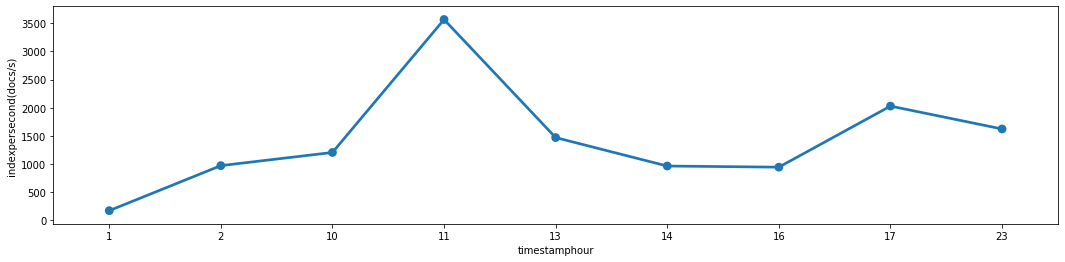

In [7]:
plt.figure(figsize=[18,4])

sns.pointplot(x=pivot.index, y='indexpersecond(docs/s)',data=pivot)

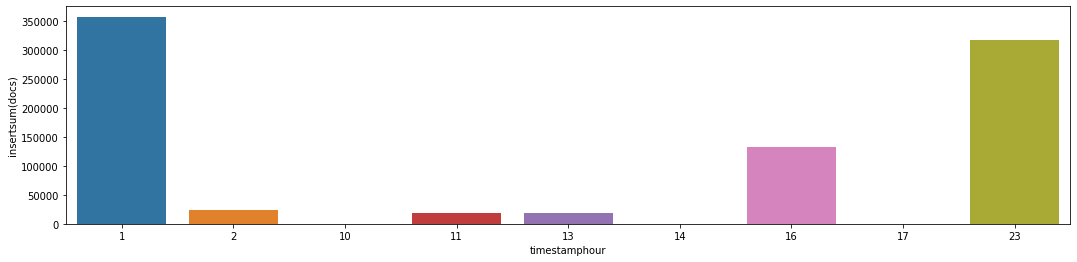

In [8]:
fig, ax3 = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(18, 4)

sns.barplot(data=pivot, x=pivot.index, y="insertsum(docs)", ax=ax3)

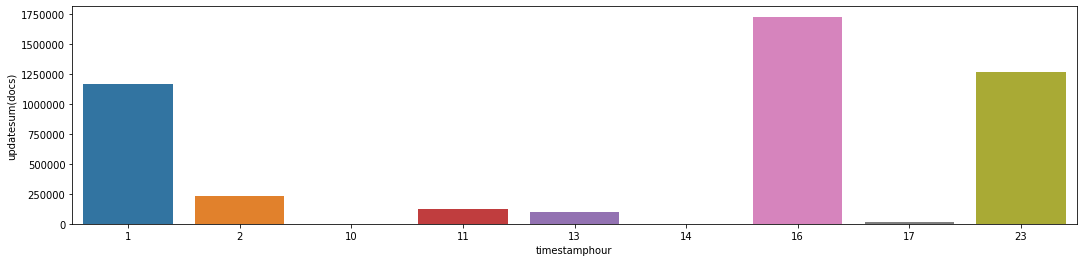

In [9]:
fig, ax4 = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(18, 4)

sns.barplot(data=pivot, x=pivot.index, y="updatesum(docs)", ax=ax4)

---

## export to excel file

In [12]:
pivot.to_excel("output.xlsx")